In [39]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.decomposition import PCA
import re

In [40]:
influencers = [
    "Teak",
    "gracefromHHP",
    "AnxiousNoMore",
    "LIZZIE LOU",
    "Sexpractice",
    "Eumak",
    "ineedhelp714",
    "howami",
    "negativeresult",
    "Badvibes",
    "Ampositive79",
    "compaq2"
]


In [41]:
df = pd.read_csv(r'C:\Users\ezio1\Documents\NLP docs\H_A_S_allCSV\ALL_COMMUNITY_merged.csv.gz', compression='gzip')

C:\Users\ezio1\AppData\Local\Temp\ipykernel_61636\43648354.py:1: DtypeWarning: Columns (9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\ezio1\Documents\NLP docs\H_A_S_allCSV\ALL_COMMUNITY_merged.csv.gz', compression='gzip')


In [42]:
df.head()

,question_url,question_user_name,question_user_id,question_msg,question_timestamp,ans_users_name,ans_user_id,ans_msg,ans_timestamp,comment_users_name,comment_user_id,comment_msg,comment_timestamp
0,https://medhelp.org/posts/Anxiety/Can-Busparbu...,caligirl1999,/personal_pages/user/4905888,\n I’m wondering if Buspar can cause ...,1/21/2024 3:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://medhelp.org/posts/Anxiety/Crippling-An...,Jasonmb96,/personal_pages/user/20933139,\n I started having problems back in ...,1/13/2024 3:29,GuitarRox,/personal_pages/user/20620809,\n Those sound like panic attacks t...,1/13/2024 14:34,GuitarRox,/user_profiles/show/20620809,https://www.mayoclinic.org/diseases-conditions...,1/13/2024 14:35
2,https://medhelp.org/posts/Anxiety/Crippling-An...,Jasonmb96,/personal_pages/user/20933139,\n I started having problems back in ...,1/13/2024 3:29,GuitarRox,/personal_pages/user/20620809,\n Those sound like panic attacks t...,1/13/2024 14:34,Jasonmb96,/personal_pages/user/20933139,They sent me to a cardiologist. I’ve had x-ray...,1/13/2024 18:58
3,https://medhelp.org/posts/Anxiety/Crippling-An...,Jasonmb96,/personal_pages/user/20933139,\n I started having problems back in ...,1/13/2024 3:29,GuitarRox,/personal_pages/user/20620809,\n Those sound like panic attacks t...,1/13/2024 14:34,GuitarRox,/personal_pages/user/20620809,"Okay, so. The good news is that the issue is n...",1/13/2024 19:13
4,https://medhelp.org/posts/Anxiety/Crippling-An...,Jasonmb96,/personal_pages/user/20933139,\n I started having problems back in ...,1/13/2024 3:29,GuitarRox,/personal_pages/user/20620809,\n Those sound like panic attacks t...,1/13/2024 14:34,Jasonmb96,/personal_pages/user/20933139,It still happens to this day just not as bad. ...,1/13/2024 23:51


In [43]:
#concat the 3 username columns into one and the associated user id columns into one
# Extracting and renaming relevant columns
question_df = df[['question_user_name', 'question_user_id']].rename(columns={'question_user_name': 'user_name', 'question_user_id': 'user_id'})
answer_df = df[['ans_users_name', 'ans_user_id']].rename(columns={'ans_users_name': 'user_name', 'ans_user_id': 'user_id'})
comment_df = df[['comment_users_name', 'comment_user_id']].rename(columns={'comment_users_name': 'user_name', 'comment_user_id': 'user_id'})

# Concatenating the dataframes
combined_df = pd.concat([question_df, answer_df, comment_df], ignore_index=True)

# Dropping rows where either column is NaN (as these would not represent a valid user name-ID pair)
combined_cleaned_df = combined_df.dropna().reset_index(drop=True)
#drop duplicates
combined_cleaned_df = combined_cleaned_df.drop_duplicates().reset_index(drop=True)
combined_cleaned_df.head()

,user_name,user_id
0,caligirl1999,/personal_pages/user/4905888
1,Jasonmb96,/personal_pages/user/20933139
2,jim45259,/personal_pages/user/2177013
3,Amesdale04,/personal_pages/user/20926806
4,GettingOlder,/personal_pages/user/446049


In [44]:
# Adding "https://medhelp.org" to the user_id column
combined_cleaned_df['user_id'] = 'https://medhelp.org' + combined_cleaned_df['user_id']

combined_cleaned_df.head()

,user_name,user_id
0,caligirl1999,https://medhelp.org/personal_pages/user/4905888
1,Jasonmb96,https://medhelp.org/personal_pages/user/20933139
2,jim45259,https://medhelp.org/personal_pages/user/2177013
3,Amesdale04,https://medhelp.org/personal_pages/user/20926806
4,GettingOlder,https://medhelp.org/personal_pages/user/446049


In [45]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Assuming 'combined_cleaned_df' is your existing dataframe with user_name and user_id columns
# Make sure to read your dataframe here if not already loaded
# combined_cleaned_df = pd.read_csv('path_to_your_dataframe.csv')

headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36',
}

def scrape_user_data(url):
    response = requests.get(url, headers=headers)
    html_content = response.text
    soup = BeautifulSoup(response.content, 'html.parser')

    # Scrape month and year
    about_me_div = soup.find('div', class_='bottom float_fix')
    month, year = '', ''
    if about_me_div:
        member_since_text = about_me_div.find('div', class_='section').text
        if 'since' in member_since_text:
            member_since = member_since_text.split('since ')[1]
            month = member_since.split()[0]
            year = member_since.split()[1]

    # Scrape interests
    interests_show = soup.find('span', class_='interests_show')
    interests = interests_show.text.split(',') if interests_show else []

    # Scrape trackers
    trackers = [tracker.text.strip() for tracker in soup.find_all('div', class_='ut_side_link')]

    # Scrape communities
    communities = [tag.parent.text for tag in soup.find_all("img", class_="c_disc_icon_xs icon_img_ww")]

    soup_2 = BeautifulSoup(html_content, 'html.parser')
    
    match = re.search(r"\$mwidgetHelper\.setTitle\('Friends \((\d+)\)'\);", html_content)

    # Check if we found a match
    if match:
        # Extract the number from the first capturing group
        friends_count = int(match.group(1))
    else:
        friends_count = 0  # Default to 0 if not found

    
    
        
    return month, year, interests, trackers, communities, friends_count

# Initialize columns for the new data
for column in ['month', 'year', 'interests', 'trackers', 'communities', 'friend_count']:
    combined_cleaned_df[column] = None

# Iterate over the dataframe and scrape data for each user
for index, row in combined_cleaned_df.iterrows():
    try:
        month, year, interests, trackers, communities, friend_count = scrape_user_data(row['user_id'])
        
        combined_cleaned_df.at[index, 'month'] = month
        combined_cleaned_df.at[index, 'year'] = year
        combined_cleaned_df.at[index, 'interests'] = interests
        combined_cleaned_df.at[index, 'trackers'] = trackers
        combined_cleaned_df.at[index, 'communities'] = communities
        combined_cleaned_df.at[index, 'friend_count'] = friend_count
    except Exception as e:
        print(f"Error scraping data for {row['user_id']}: {e}")



Error scraping data for https://medhelp.orghttps://www.medhelp.org/personal_pages/user/6347121: HTTPSConnectionPool(host='medhelp.orghttps', port=443): Max retries exceeded with url: //www.medhelp.org/personal_pages/user/6347121 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001D734EC7950>: Failed to resolve 'medhelp.orghttps' ([Errno 11001] getaddrinfo failed)"))
Error scraping data for https://medhelp.orghttps://www.medhelp.org/personal_pages/user/16743280: HTTPSConnectionPool(host='medhelp.orghttps', port=443): Max retries exceeded with url: //www.medhelp.org/personal_pages/user/16743280 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001D705649050>: Failed to resolve 'medhelp.orghttps' ([Errno 11001] getaddrinfo failed)"))
Error scraping data for https://medhelp.orghttps://www.medhelp.org/personal_pages/user/11224105: HTTPSConnectionPool(host='medhelp.orghttps', port=443): Max retries exceeded with url: //www.me

KeyboardInterrupt: 

In [16]:
# Iterate over the dataframe and scrape data for each user starting from row 8422
for index, row in combined_cleaned_df.iloc[8422:].iterrows():
    try:
        month, year, interests, trackers, communities, friend_count = scrape_user_data(row['user_id'])
        
        combined_cleaned_df.at[index, 'month'] = month
        combined_cleaned_df.at[index, 'year'] = year
        combined_cleaned_df.at[index, 'interests'] = interests
        combined_cleaned_df.at[index, 'trackers'] = trackers
        combined_cleaned_df.at[index, 'communities'] = communities
        combined_cleaned_df.at[index, 'friend_count'] = friend_count
    except Exception as e:
        print(f"Error scraping data for {row['user_id']}: {e}")

Error scraping data for https://medhelp.org/personal_pages/user/959034: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


KeyboardInterrupt: 

In [17]:
# # Optionally, save the updated dataframe to a new CSV file
combined_cleaned_df.to_csv('updated_dataframe.csv', index=False)


In [22]:
influencers_df = combined_cleaned_df[combined_cleaned_df['user_name'].isin(influencers)].reset_index(drop=True)
influencers_df = influencers_df.drop_duplicates(subset='user_name').reset_index(drop=True)
influencer_data = []

for index, row in influencers_df.iterrows():
    try:
        month, year, interests, trackers, communities, friend_count = scrape_user_data(row['user_id'])
        
        influencer_data.append({
            'username': row['user_name'],
            'user_id': row['user_id'],
            'month': month,
            'year': year,
            'interests': interests,
            'trackers': trackers,
            'communities': communities,
            'friend_count': friend_count
        })
    except Exception as e:
        print(f"Error scrapping dat for {row['user_name']}: {e}")

influencers_df = pd.DataFrame(influencer_data)

influencers_df


,username,user_id,month,year,interests,trackers,communities,friend_count
0,Badvibes,https://medhelp.org/personal_pages/user/374951,Dec,2007,[],[],[],0
1,howami,https://medhelp.org/personal_pages/user/1931366,Dec,2011,[],[],"[Anxiety, HIV Prevention]",0
2,gracefromHHP,https://medhelp.org/personal_pages/user/101028,Sep,2005,[],[],"[Herpes, STDs / STIs, Human Papillomavirus (HPV)]",11
3,LIZZIE LOU,https://medhelp.org/personal_pages/user/186166,Feb,2007,[\nHIV/Aids\n],[],"[HIV Prevention, Thyroid Cancer, Addiction: Li...",31
4,Teak,https://medhelp.org/personal_pages/user/173692,Dec,2006,[],[],"[HIV, Living With, HIV Prevention]",3
5,compaq2,https://medhelp.org/personal_pages/user/350905,Dec,2007,[],[],[],0
6,Ampositive79,https://medhelp.org/personal_pages/user/5814801,Jul,2013,[],[],"[HIV Prevention, Autoimmune Disorders , Infect...",0
7,Eumak,https://medhelp.org/personal_pages/user/4260727,Nov,2012,[],[],"[HIV Prevention, General Health]",0
8,ineedhelp714,https://medhelp.org/personal_pages/user/2129475,Apr,2012,[],[],[HIV Prevention],0
9,Sexpractice,https://medhelp.org/personal_pages/user/1538701,Dec,2010,[],[],[],0


In [23]:
influencers_df.to_csv('influencers_data.csv', index=False)

In [25]:
updated_df_sample = combined_cleaned_df.head(10)
updated_df_sample.to_csv('updated_df_sample.csv', index=False)

C:\Users\ezio1\AppData\Local\Temp\ipykernel_61636\1117735486.py:7: DtypeWarning: Columns (0,1,2,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  general_df = pd.read_csv(r'C:\Users\ezio1\Documents\NLP docs\updated_dataframe.csv')


Influencers - Friend Count Summary Statistics:
count    12.000000
mean      3.750000
std       9.156468
min       0.000000
25%       0.000000
50%       0.000000
75%       0.750000
max      31.000000
Name: friend_count, dtype: float64

General Users - Friend Count Summary Statistics:
count    12401.000000
mean         1.806064
std         12.824210
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        703.000000
Name: friend_count, dtype: float64
Influencers - Summary Statistics:
       num_communities  num_interests  num_trackers
count        12.000000      12.000000          12.0
mean          3.166667       0.166667           0.0
std           5.424412       0.389249           0.0
min           0.000000       0.000000           0.0
25%           0.750000       0.000000           0.0
50%           2.000000       0.000000           0.0
75%           3.000000       0.000000           0.0
max          20.000000       1.000000           0.0

Ge

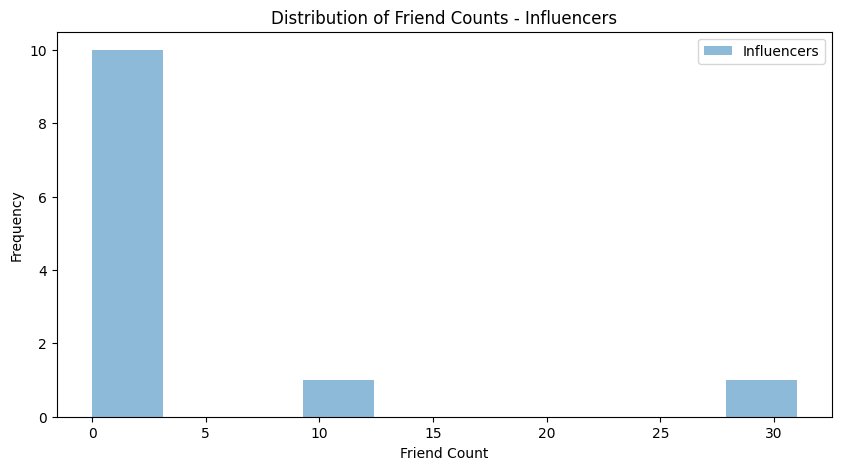

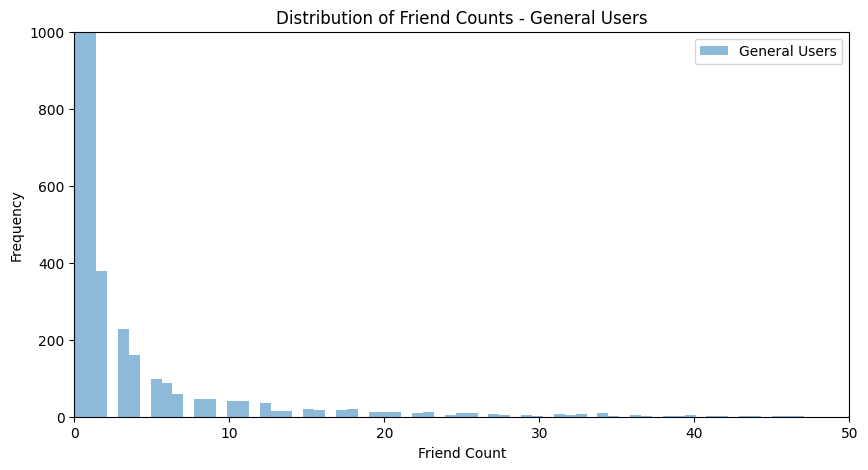

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

# Load the data
influencers_df = pd.read_csv(r'C:\Users\ezio1\Documents\NLP docs\influencers_data.csv')
general_df = pd.read_csv(r'C:\Users\ezio1\Documents\NLP docs\updated_dataframe.csv')

# Function to safely convert string representations of lists into actual lists
def eval_lists(s):
    if pd.isna(s) or s == "nan":
        return []
    try:
        return literal_eval(str(s))
    except (ValueError, SyntaxError):
        return []

# Apply the function to 'interests', 'trackers', and 'communities' columns
columns_to_convert = ['interests', 'trackers', 'communities']
for col in columns_to_convert:
    influencers_df[col] = influencers_df[col].apply(eval_lists)
    general_df[col] = general_df[col].apply(eval_lists)

# Calculate and print summary statistics for 'friend_count'
print("Influencers - Friend Count Summary Statistics:")
print(influencers_df['friend_count'].describe())
print("\nGeneral Users - Friend Count Summary Statistics:")
print(general_df['friend_count'].describe())

# Function to flatten lists and get counts
def get_counts(df, column):
    return df[column].explode().value_counts()

# Compare interests
influencer_interests = get_counts(influencers_df, 'interests')
general_interests = get_counts(general_df, 'interests')

# Compare communities
influencer_communities = get_counts(influencers_df, 'communities')
general_communities = get_counts(general_df, 'communities')

# Count the number of communities, interests, and trackers
influencers_df['num_communities'] = influencers_df['communities'].apply(len)
influencers_df['num_interests'] = influencers_df['interests'].apply(len)
influencers_df['num_trackers'] = influencers_df['trackers'].apply(len)

general_df['num_communities'] = general_df['communities'].apply(len)
general_df['num_interests'] = general_df['interests'].apply(len)
general_df['num_trackers'] = general_df['trackers'].apply(len)

# Calculate and print summary statistics for interests, communities, and trackers
print("Influencers - Summary Statistics:")
print(influencers_df[['num_communities', 'num_interests', 'num_trackers']].describe())

print("\nGeneral Users - Summary Statistics:")
print(general_df[['num_communities', 'num_interests', 'num_trackers']].describe())

# Compare the distribution of friend counts between influencers and general users
plt.figure(figsize=(10, 5))
plt.hist(influencers_df['friend_count'], bins=10, alpha=0.5, label='Influencers')
plt.title('Distribution of Friend Counts - Influencers')
plt.xlabel('Friend Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(general_df['friend_count'], bins=1000, alpha=0.5, label='General Users')
plt.title('Distribution of Friend Counts - General Users')
plt.xlabel('Friend Count')
plt.ylabel('Frequency')
plt.xlim(0, 50)
plt.ylim(0, 1000)
plt.legend()
plt.show()
